In [1]:
%matplotlib inline

In [2]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

## Generating Small World Networks

### Random rewiring procedure

/home/dario/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


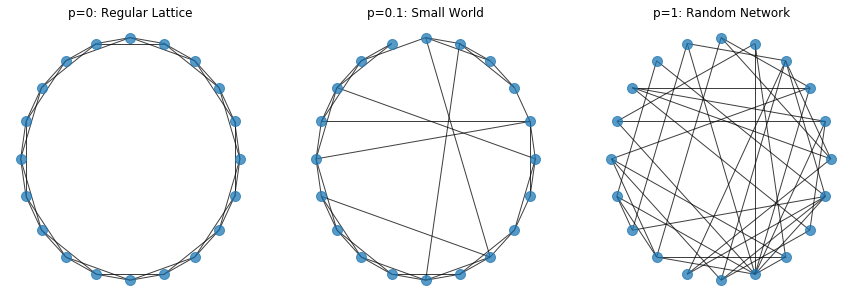

In [3]:
G_random_0 = nx.generators.random_graphs.connected_watts_strogatz_graph(n=20, k=4, p=0)
G_random_10 = nx.generators.random_graphs.connected_watts_strogatz_graph(n=20, k=4, p=0.1)
G_random_100 = nx.generators.random_graphs.connected_watts_strogatz_graph(n=20, k=4, p=1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))

nx.draw_circular(G_random_0, node_size=100, ax=ax1, alpha=.75)
nx.draw_circular(G_random_10, node_size=100, ax=ax2, alpha=.75)
nx.draw_circular(G_random_100, node_size=100, ax=ax3, alpha=.75)

ax1.set_title('p=0: Regular Lattice')
ax2.set_title('p=0.1: Small World')
ax3.set_title('p=1: Random Network')

fig.savefig('rewiring_process.png')
plt.show()

### Path Length vs Clustering Coefficient

Chosen parameters as in paper:
1. Generate 20 random networks
2. Rewiring probablities range from 0.0001 - 1
3. N=1000
4. Average degree k = 10

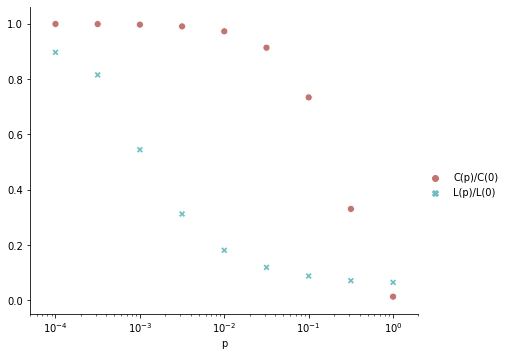

In [4]:
p = 10 ** np.arange(-4, 0.5, 0.5)
k = 10
N = 1000

global_clustering = []
average_shortest_path = []

# Graph with p=0 to normalize results
reg_graph = nx.watts_strogatz_graph(N, k, 0)
c_0 = nx.average_clustering(reg_graph)
l_0 = nx.average_shortest_path_length(reg_graph)

# create 20 graphs
for i in range(1, 21):
    
    single_graph_global_clustering = []
    single_graph_average_shortest_path = []
    
    for i in p:
        graph = nx.connected_watts_strogatz_graph(N, k, i)
        single_graph_global_clustering.append(nx.average_clustering(graph))
        single_graph_average_shortest_path.append(nx.average_shortest_path_length(graph))

    global_clustering.append(single_graph_global_clustering)
    average_shortest_path.append(single_graph_average_shortest_path)
    
# convert into numpy array, makes it easy to calculate averages in 2D array
global_clustering = np.array(global_clustering)
average_shortest_path = np.array(average_shortest_path)
avg_global_clustering = global_clustering.mean(axis=0)
avg_average_shortest_path = average_shortest_path.mean(axis=0)

df = pd.DataFrame({'p': p, 'C(p)/C(0)': [i/c_0 for i in avg_global_clustering], 'L(p)/L(0)': [i/l_0 for i in avg_average_shortest_path]})
df = pd.melt(df, id_vars=['p'], value_vars=['C(p)/C(0)', 'L(p)/L(0)'], var_name='')

g = sns.relplot(x='p', y='value', hue='', style='', data=df, palette=sns.hls_palette(2, s=.4), aspect=1.25, s=50).set(xscale='log', xlim=(0.00005,2), ylabel='')

g.savefig('clustering_vs_shortestpath.png')
plt.show(g)

## Empirical Examples of Small World Networks

Note: In order to be able to import and work with G_celegansneural, I had to delete some duplicate edges in the graph. Also, we treat the graph as undirected, as also done in the original paper.

Calculate for real networks the following metrics:
1. L(acutal)
2. L(random)
3. C(actual)
4. C(random)

The random networks are created with the same number of nodes and the average degree of their actual representations. For the C. elegans all edges are treated as undirected and unweighted.

In [10]:
G_power = nx.read_gml('data_project/power.gml', label='id')
G_celegansneural = nx.read_gml('data_project/celegansneural.gml')
G_facebook = nx.read_gml('data_project/graph_facebook.gml')

# random networks
G_power_random = nx.connected_watts_strogatz_graph(
    len(G_power.nodes()), int(np.average([i for node, i in G_power.degree()])), 1)

G_celegansneural_random = nx.connected_watts_strogatz_graph(
    len(G_celegansneural.nodes()), int(np.average([i for node, i in G_celegansneural.degree()])), 1)

G_facebook_random = nx.connected_watts_strogatz_graph(
    len(G_facebook.nodes()), int(np.average([i for node, i in G_facebook.degree()])), 1)


# Power grid
L_actual_power = nx.average_shortest_path_length(G_power)
L_random_power = nx.average_shortest_path_length(G_power_random)
C_acutal_power = nx.average_clustering(G_power)
C_random_power = nx.average_clustering(G_power_random)

# C. elegans
L_actual_elegans = nx.average_shortest_path_length(G_celegansneural)
L_random_elegans = nx.average_shortest_path_length(G_celegansneural_random)
C_acutal_elegans = nx.average_clustering(G_celegansneural)
C_random_elegans = nx.average_clustering(G_celegansneural_random)

# Facebook
L_actual_facebook = nx.average_shortest_path_length(G_facebook)
L_random_facebook = nx.average_shortest_path_length(G_facebook_random)
C_actual_facebook = nx.average_clustering(G_facebook)
C_random_facebook = nx.average_clustering(G_facebook_random)


df = pd.DataFrame({
    'Dataset': ['Power grid', 'C. elegans', 'Facebook'],
    'L(actual)': [L_actual_power, L_actual_elegans, L_actual_facebook],
    'L(random)': [L_random_power, L_random_elegans, L_random_facebook],
    'C(actual)': [C_acutal_power, C_acutal_elegans, C_actual_facebook],
    'C(random)': [C_random_power, C_random_elegans, C_random_facebook]
})

df


,Dataset,L(actual),L(random),C(actual),C(random)
0,Power grid,18.989185,98.687618,0.080104,0.000000
1,C. elegans,3.071560,2.451611,0.173557,0.043549
2,Facebook,3.692507,2.630987,0.605547,0.010163


There is a problem with the above method, namely:
- Watts strogatz graph generator of networkx does only accept integers, not floats. The power grid has an average degree of 2.67. Difference between 2 and 3 might be quite noticable.

For that reason we tried the following **new approach:**

Instead of generating a random network from a regular lattice with the same properties as the original network, we started from the real network and performed a series of double edge swaps.
Networkx has the function to perform connected **double edge swaps**. According to Milo et al (2003) roughly **100 * # edges** swaps are required to obtain a fully randomized network.

The result is a randomized network which is degree-perserving. Unexpectedly, the result of this method turns out to be closer to the results of the original paper.

From Milo, R., Kashtan, N., Itzkovitz, S., Newman, M. E., & Alon, U. (2003). On the uniform generation of random graphs with prescribed degree sequences. arXiv preprint cond-mat/0312028.

Mihail, C. G. M., & Zegura, E. (2003). The markov chain simulation method for generating connected power law random graphs. In Proceedings of the Fifth Workshop on Algorithm Engineering and Experiments (Vol. 111, p. 16). Philadelphia: SIAM,.

In [11]:
G_power_random = G_power.copy()
G_celegansneural_random = G_celegansneural.copy().to_undirected()
G_facebook_random = G_facebook.copy()

for i in range(0, len(G_power_random.edges()) * 100):
    nx.connected_double_edge_swap(G_power_random)

for i in range(0, len(G_celegansneural_random.edges()) * 100):
    nx.connected_double_edge_swap(G_celegansneural_random)

for i in range(0, len(G_facebook_random.edges()) * 100):
    nx.connected_double_edge_swap(G_facebook_random)

# Power grid
L_actual_power = nx.average_shortest_path_length(G_power)
L_random_power = nx.average_shortest_path_length(G_power_random)
C_acutal_power = nx.average_clustering(G_power)
C_random_power = nx.average_clustering(G_power_random)

# C. elegans
L_actual_elegans = nx.average_shortest_path_length(G_celegansneural)
L_random_elegans = nx.average_shortest_path_length(G_celegansneural_random)
C_acutal_elegans = nx.average_clustering(G_celegansneural)
C_random_elegans = nx.average_clustering(G_celegansneural_random)

# Facebook
L_actual_facebook = nx.average_shortest_path_length(G_facebook)
L_random_facebook = nx.average_shortest_path_length(G_facebook_random)
C_actual_facebook = nx.average_clustering(G_facebook)
C_random_facebook = nx.average_clustering(G_facebook_random)

df = pd.DataFrame({
    'Dataset': ['Power grid', 'C. elegans', 'Facebook'],
    'L(actual)': [L_actual_power, L_actual_elegans, L_actual_facebook],
    'L(random)': [L_random_power, L_random_elegans, L_random_facebook],
    'C(actual)': [C_acutal_power, C_acutal_elegans, C_actual_facebook],
    'C(random)': [C_random_power, C_random_elegans, C_random_facebook]
})

df


,Dataset,L(actual),L(random),C(actual),C(random)
0,Power grid,18.989185,8.725193,0.080104,0.000890
1,C. elegans,3.071560,2.397830,0.173557,0.134677
2,Facebook,3.692507,2.594260,0.605547,0.063226


## Model of disease spreading

This function returns the share of infected (or removed) nodes with beta as in input, which is the probability that a neighbour node is infected.

In [6]:
def get_infected_nodes(g,seed,maxTime,beta):
    
    susceptible = 0
    infected = 1
    removed = 2
    
    for i in g.nodes():
        g.node[i]['state'] = susceptible
    g.node[seed]['state'] = infected  
    
    for t in np.arange(maxTime):

        for i in g.nodes():
            if g.node[i]['state'] == infected:
                for j in g.neighbors(i):
                    if g.node[j]['state'] == susceptible:
                        if np.random.rand() < beta:
                            g.node[j]['state'] = infected
                if np.random.rand() < 1:
                    g.node[i]['state'] = removed
                    
    inf_list = np.where([g.node[i]['state']==infected for i in g.nodes()])[0]
    sus_list = np.where([g.node[i]['state']==susceptible for i in g.nodes()])[0]
    rem_list = np.where([g.node[i]['state']==removed for i in g.nodes()])[0]
    
    # return the ratio of infected
    # i look at infected as either still infected or dead/removed
    return (len(inf_list) + len(rem_list)) / len(g.nodes())

The following function returns the time it takes to fully infect the network. Each round all neighbour nodes of the currently infected nodes are infected (probability = 1). The previously invected nodes are then removed and no longer looked at. As soon as all of the nodes are either infected or removed, the function terminates.

In [3]:
def get_time_to_fully_infect(g,seed):
    
    susceptible = 0
    infected = 1
    removed = 2
    
    for i in g.nodes():
        g.node[i]['state'] = susceptible
    g.node[seed]['state'] = infected  
    
    for t in np.arange(1000):
        
        # get all infected nodes and their neibours
        inf_list = np.where([g.node[i]['state']==infected for i in g.nodes()])[0]
        
        # print(inf_list)
        for inf_node in inf_list:
            for j in g.neighbors(inf_node):
                 if g.node[j]['state'] == susceptible:
                        g.node[j]['state'] = infected
                        
            g.node[inf_node]['state'] = removed
        
        inf_list = np.where([g.node[i]['state']==infected for i in g.nodes()])[0]
        sus_list = np.where([g.node[i]['state']==susceptible for i in g.nodes()])[0]
        rem_list = np.where([g.node[i]['state']==removed for i in g.nodes()])[0]
        
        if len(inf_list) + len(rem_list) == len(g.nodes()):
            return t

The bisection method is used to iteratively find the smallest probability of infection such that half of the population will be infected after enough time steps.

In [4]:
def bisect(G):
    left = 0
    right = 1
    
    for i in range(0,10):
        r = (left + right) / 2
        x = get_infected_nodes(G.copy(), 0, 100, r)
        
        if x > 0.5:
            right = r
        elif x < 0.5:
            left = r
        else:
            return r
    
    return (left + right)/2

Next step is to find out when at least half of population is infected. Question here is: how many steps are enough? We are choosing 100 time steps.

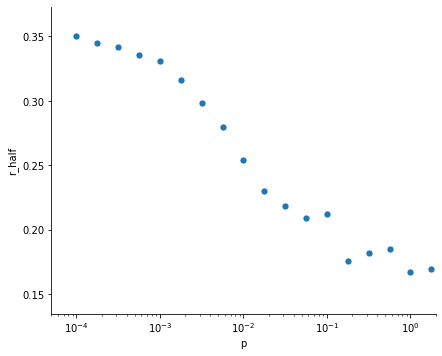

In [8]:
p_rewire = 10 ** np.arange(-4, 1.25, 0.25)

r_half_avgs = []

for p in p_rewire:
    G = nx.connected_watts_strogatz_graph(1000, 10, p)
    
    r_half = []
    
    for i in range(0,20):
        r_half_temp = bisect(G)
        r_half.append(r_half_temp)
        
    r_half_avg_temp = np.average(r_half)
    r_half_avgs.append(r_half_avg_temp)


df = pd.DataFrame({'p': p_rewire, 'r_half': r_half_avgs})
    
g = sns.relplot(x='p', y='r_half', data=df, aspect=1.25, s=50).set(xscale='log', xlim=(0.00005,2))

g.savefig('r_half.png')
plt.show(g)

The following part shows the relationship between the time required for a maximally infectious desease (probablity of infection = 1) and the rewiring probability p.

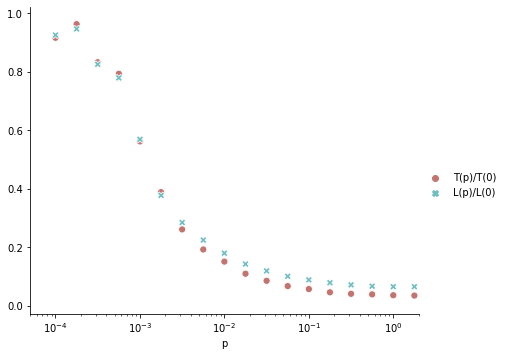

In [9]:
p_rewire = 10 ** np.arange(-4, 1.25, 0.25)

t_avg = []
shortest_path = []

for p in p_rewire:
    t_avg_temp = []
    shortest_path_temp = []
    
    for i in range(0,10):

        G = nx.connected_watts_strogatz_graph(1000, 10, p)
        shortest_path_temp.append(nx.average_shortest_path_length(G))
        t_avg_temp.append(get_time_to_fully_infect(G, 0))
    
    t_avg.append(np.average(t_avg_temp))
    shortest_path.append(np.average(shortest_path_temp))
    
    
G = nx.connected_watts_strogatz_graph(1000, 10, 0)
t_0 = get_time_to_fully_infect(G, 0)
l_0 = nx.average_shortest_path_length(G)

df = pd.DataFrame({'p': p_rewire, 'T(p)/T(0)': [t/t_0 for t in t_avg], 'L(p)/L(0)': [l/l_0 for l in shortest_path]})
df = pd.melt(df, id_vars=['p'], value_vars=['T(p)/T(0)', 'L(p)/L(0)'], var_name='')

g = sns.relplot(x='p', y='value', hue='', style='', data=df, palette=sns.hls_palette(2, s=.4), aspect=1.25, s=50).set(xscale='log', xlim=(0.00005,2), ylabel='')

g.savefig('time_to_full_infection.png')
plt.show(g)